# 📌 ADIA Lab Structural Break Challenge  

**Assalam o Alaikum👋**  
In this notebook, we are going to explore the concept of **structural breaks (regime shifts)** – basically jab data ka trend, mean, or variance suddenly change ho jaye 📊.  

Structural break detection is an important problem because real-world data kabhi bhi smooth aur stable nahi hota. Kabhi kabhi beech me major shifts aate hain jo forecasting aur analysis dono ko effect kar dete hain.  

---

## 🔎 Challenge Overview  

Welcome to the **ADIA Lab Structural Break Challenge!**  
In this competition, you will analyze **univariate time series data** to determine whether a **structural break** has occurred at a specified boundary point.  

### 📖 What is a Structural Break?  

A **structural break** occurs when the process governing the data generation changes at a certain point in time.  
These changes can be subtle or dramatic, and detecting them accurately is crucial across domains:  

- 🌦 **Climatology** → shifts in long-term weather patterns  
- 🏭 **Industrial Monitoring** → detecting sudden machine behavior changes  
- 💹 **Finance** → market crashes or regime shifts  
- 🏥 **Healthcare** → sudden change in patient health indicators  

![Structural Break Example](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/structural-break/quickstarters/baseline/images/example.png)  

---

## 📝 Our Task  

For each time series in the **test set**, we need to predict a **score between `0` and `1`:**  

- `0` → No structural break at the specified boundary point  
- `1` → A structural break **did occur**  

---

## 📊 Evaluation Metric  

The challenge uses **ROC AUC (Area Under the Receiver Operating Characteristic Curve)** as the evaluation metric:  

- **ROC AUC ≈ 0.5** → No better than random guessing  
- **ROC AUC → 1.0** → Perfect detection performance  

More about ROC AUC: [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)  

---

## 📂 Notebook Flow 🚀  

1. **Exploratory Data Analysis (EDA)** – visualize aur samajhenge dataset.  
2. **Methods** – different techniques (statistical + ML-based) try karenge for break detection.  
3. **Evaluation** – compare karenge results aur dekhenge kaun sa method best perform karta hai.  

---

⚡ **Goal**: A clean, reproducible, and easy-to-follow Kaggle-style notebook – jahan beginner bhi seekh le aur advanced banda bhi enjoy kare.  

**Chalo shuru karte hain 🚀**  


In [2]:
# import Important Libraries

!pip install antropy --quiet
!pip install PyWavelets --quiet


In [4]:
import os
import typing

# Import your dependencies
import joblib
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import sklearn.metrics
from scipy.stats import wasserstein_distance  # 1D Earth Mover's Distance
from scipy.stats import skew, kurtosis, ks_2samp
from scipy.stats import wasserstein_distance

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay
from scipy.stats import skew, kurtosis, ks_2samp, mannwhitneyu, wasserstein_distance
from scipy.signal import welch, hilbert
from statsmodels.tsa.stattools import acf, pacf

from scipy.signal import welch
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Crunch CLI SETUP

In [6]:
### CRunch CLI Setup
%pip install crunch-cli --upgrade --quiet --progress-bar off
!crunch setup-notebook structural-break xm5KtLMSrYthCM1fOS5CsfpQ


import crunch

# Load the Crunch Toolings
crunch = crunch.load_notebook()

# Load the data simply
X_train, y_train, X_test = crunch.load_data()

Note: you may need to restart the kernel to use updated packages.
crunch-cli, version 7.5.0
main.py: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/submissions/29471/main.py (32823 bytes)
notebook.ipynb: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/submissions/29471/notebook.ipynb (578687 bytes)
requirements.txt: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/submissions/29471/requirements.original.txt (257 bytes)
data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 

### BASIC EDA

In [7]:
# --- Dataset Overview ---
print("📂 Total training subsequences:", len(X_train))
print(X_train.shape)
print("📂 Total test subsequences:", len(X_test))
print("📂 y_train length:", len(y_train))

# --- Target Labels ---
print("\n📊 y_train distribution:")
print(y_train.value_counts(normalize=True))
print(y_train.value_counts())

# --- Check Nulls in y_train ---
print("\n📉 Missing values in y_train:", y_train.isnull().sum())

# --- Test set EDA (corrected) ---
print("\n📂 Test set overview:")
print("Number of test series:", len(X_test))
print("Shape of first 5 test series:", [np.array(df).shape for df in X_test[:5]])

# --- Nulls in X_train (safe) ---
train_nulls = 0
for x in X_train[:1000]:  # sample 1000 series
    try:
        arr = np.array(x, dtype=float)
        train_nulls += np.isnan(arr).sum()
    except:
        # non-numeric series
        train_nulls += 0

print(f"\n📉 Null values in first 1000 training series: {train_nulls}")

# --- Nulls in X_test (safe) ---
test_nulls = 0
for x in X_test:
    try:
        arr = np.array(x, dtype=float)
        test_nulls += np.isnan(arr).sum()
    except:
        test_nulls += 0

print(f"📉 Null values in test series: {test_nulls}")

# --- Example lengths of sequences ---
train_lengths = [len(x) for x in X_train[:1000]]  # sample
print(f"\n📏 Training series length stats (sample 1000):")
print("Number of datasets:", len(X_test))
print(pd.Series(train_lengths).describe())

📂 Total training subsequences: 23715734
(23715734, 2)
📂 Total test subsequences: 101
📂 y_train length: 10001

📊 y_train distribution:
structural_breakpoint
False    0.709129
True     0.290871
Name: proportion, dtype: float64
structural_breakpoint
False    7092
True     2909
Name: count, dtype: int64

📉 Missing values in y_train: 0

📂 Test set overview:
Number of test series: 101
Shape of first 5 test series: [(2779, 2), (1966, 2), (1775, 2), (3296, 2), (1995, 2)]

📉 Null values in first 1000 training series: 0
📉 Null values in test series: 0

📏 Training series length stats (sample 1000):
Number of datasets: 101
count    2.000000
mean     5.500000
std      0.707107
min      5.000000
25%      5.250000
50%      5.500000
75%      5.750000
max      6.000000
dtype: float64


## 📝 Basic EDA Notes (Updated)

- **Total Training Subsequences:** 23,715,734  
- **Total Test Subsequences:** 101  
- **y_train Length:** 10,001  

### 📊 y_train Distribution
- **Proportion:**  
  - False: 70.9%  
  - True: 29.1%  
- **Counts:**  
  - False: 7,092  
  - True: 2,909  
- Label imbalance exists → metric ROC AUC is robust to this.

### 📉 Missing Values
- **y_train:** 0  
- **X_train (first 1000 series):** 0  
- **X_test:** 0  
- No missing data → preprocessing easier.

### 📂 Test Set Overview
- Number of test series: 101  
- Shape of first 5 test series: `(2779,2), (1966,2), (1775,2), (3296,2), (1995,2)`  
- Each test series has variable length but 2 columns (probably period & value).

### 📏 Training Series Lengths (Sample 1000)
- Min: 5, Max: 6, Mean: 5.5  
- Mostly very short sequences → statistical/ML models will work on small windows.

**Notes:**  
- Dataset has **very large number of training subsequences**  
- No missing values → safe to use directly  
- Label imbalance is moderate → consider for evaluation metric  
- Next steps: visualize sample series, inspect True vs False structural breaks.


### Visualization of series

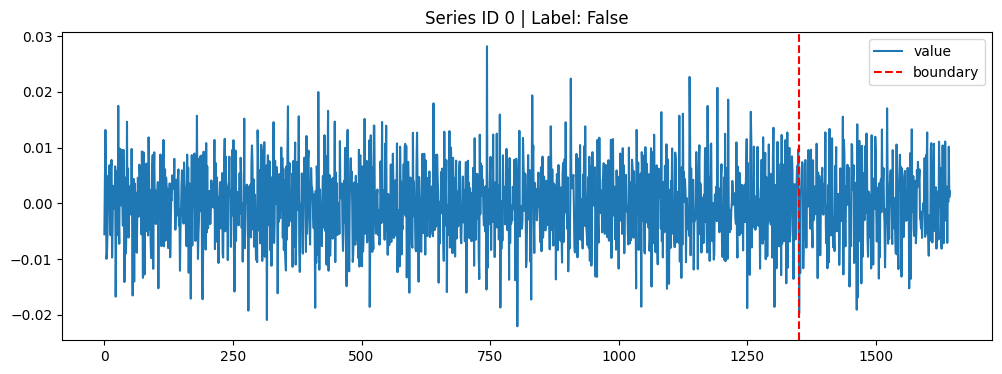

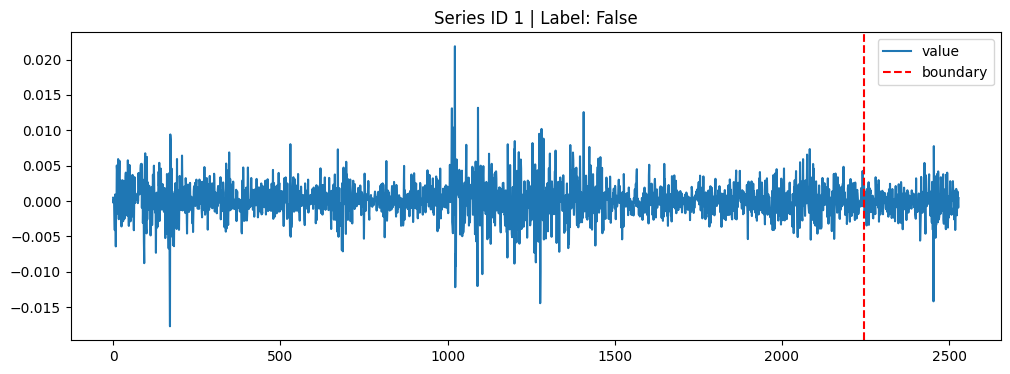

In [7]:
# visualize a single time series
def plot_series(series_id):
    df = X_train.loc[series_id]
    plt.figure(figsize=(12,4))
    plt.plot(df.index, df["value"], label="value")
    plt.axvline(x=df[df["period"]==0].index.max(), color="red", linestyle="--", label="boundary")
    plt.title(f"Series ID {series_id} | Label: {y_train.loc[series_id]}")
    plt.legend()
    plt.show()

plot_series(0)
plot_series(1)


### Length of series

In [8]:
#Length of series
series_lengths = X_train.groupby("id").size()
display(series_lengths.describe())

count    10001.000000
mean      2371.336266
std        482.645935
min       1258.000000
25%       1991.000000
50%       2369.000000
75%       2743.000000
max       3478.000000
dtype: float64

### Mean aur Std deviation comparison before and after the structural break:


Series 2 | Label: True
Before mean: 0.0003892051236000776  | std: 0.017221361838717496
After  mean: 0.0017896691818350308  | std: 0.022899626080259385


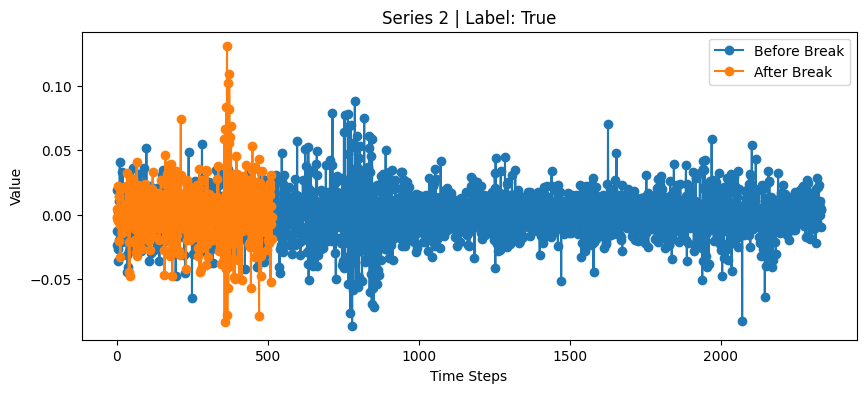

Series 0 | Label: False
Before mean: 1.45894149863421e-05  | std: 0.006987461835288747
After  mean: 6.371869815417522e-06  | std: 0.006876778367900677


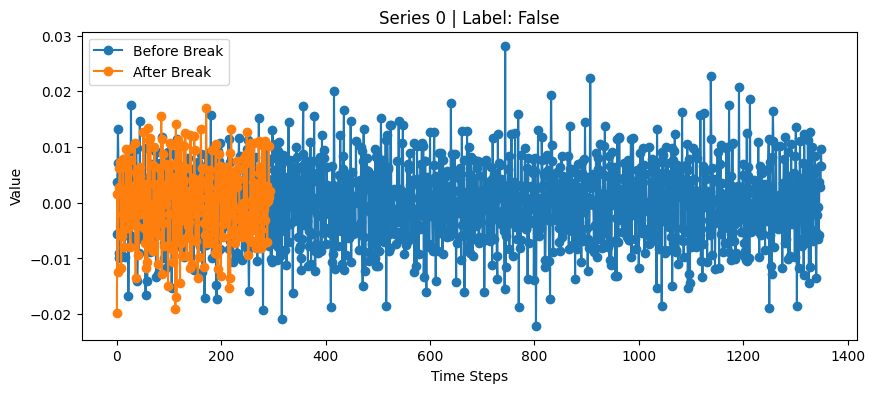

In [9]:
# Get indices
true_idx = y_train[y_train==True].index[0]
false_idx = y_train[y_train==False].index[0]

def compare_stats_plot(series_id):
    df = X_train.loc[series_id]  # assuming period & value columns
    before = df[df["period"]==0]["value"]
    after  = df[df["period"]==1]["value"]
    
    print(f"Series {series_id} | Label: {y_train.loc[series_id]}")
    print("Before mean:", before.mean(), " | std:", before.std())
    print("After  mean:", after.mean(), " | std:", after.std())
    
    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(before.values, marker='o', label='Before Break')
    plt.plot(after.values, marker='o', label='After Break')
    plt.title(f"Series {series_id} | Label: {y_train.loc[series_id]}")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

# Compare True series
compare_stats_plot(true_idx)

# Compare False series
compare_stats_plot(false_idx)


## 🔍 Structural Break Interpretation

**Series 0 | Label: False**  
- Mean before: 1.46e-5 | after: 6.37e-6  
- Std before: 0.00699 | after: 0.00688  
- Observation: Mean and std are almost the same → **No significant change**  
- Conclusion: **No structural break**  

**Series 2 | Label: True**  
- Mean before: 0.000389 | after: 0.00179  
- Std before: 0.0172 | after: 0.0229  
- Observation: Both mean and std increased → **Noticeable change in distribution**  
- Conclusion: **Structural break exists**  

**Summary:**  
- **False series:** stable values, no break  
- **True series:** sudden change in mean/variance → structural break


### Compariseon true and fase labels

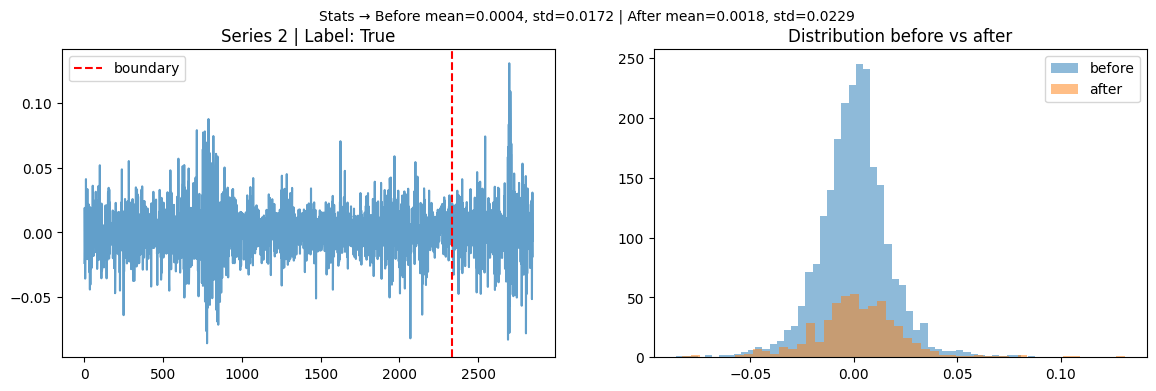

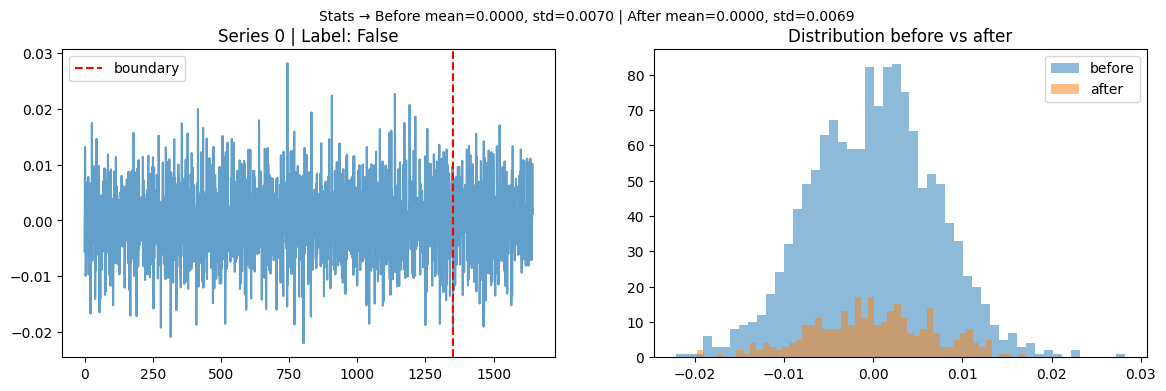

In [10]:
# Compariseon true and fase labels
def compare_true_false(X_train, y_train, true_id=None, false_id=None):
    # agar ID pass na ki ho to first True/False pick karo
    if true_id is None:
        true_id = y_train[y_train == True].index[0]
    if false_id is None:
        false_id = y_train[y_train == False].index[0]
    
    for series_id in [true_id, false_id]:
        df = X_train.loc[series_id]
        before = df[df["period"]==0]["value"]
        after  = df[df["period"]==1]["value"]
        
        fig, axes = plt.subplots(1, 2, figsize=(14,4))
        
        # time series plot
        axes[0].plot(df.index, df["value"], alpha=0.7)
        boundary = df[df["period"]==0].index.max()
        axes[0].axvline(boundary, color="red", linestyle="--", label="boundary")
        axes[0].set_title(f"Series {series_id} | Label: {y_train.loc[series_id]}")
        axes[0].legend()
        
        # histogram compare
        axes[1].hist(before, bins=50, alpha=0.5, label="before")
        axes[1].hist(after, bins=50, alpha=0.5, label="after")
        axes[1].set_title("Distribution before vs after")
        axes[1].legend()
        
        plt.suptitle(f"Stats → Before mean={before.mean():.4f}, std={before.std():.4f} | After mean={after.mean():.4f}, std={after.std():.4f}", fontsize=10)
        plt.show()

# run example
compare_true_false(X_train, y_train)



In [11]:
X_test[0]

value  period
id    time                  
10001 0     0.010753       0
      1    -0.031915       0
      2    -0.010989       0
      3    -0.011111       0
      4     0.011236       0
...              ...     ...
      2774 -0.013937       1
      2775 -0.015649       1
      2776 -0.009744       1
      2777  0.025375       1
      2778 -0.001515       1

[2779 rows x 2 columns]

## 🔹 Advanced Feature Engineering Strategy

Our goal is to transform raw time series data into **informative features** that capture both statistical properties and structural changes between "before" and "after" segments. This enables machine learning models to detect subtle patterns indicative of structural breaks or anomalies.

---

### 1️⃣ Segmentation
- Each time series is divided into two segments based on the `period` column:
  - **Before (period=0)**
  - **After  (period=1)**
- Null values are dropped to ensure robust calculations.
- Short segments (<8 samples) are skipped to maintain reliability.

---

### 2️⃣ Basic Statistical Features
For both segments, compute:
- **Mean & Median** → central tendency
- **Standard Deviation (std)** → spread
- **Interquartile Range (IQR)** → variability

**Differences & Ratios:**
- Mean difference (`mean_diff = after_mean - before_mean`)
- Median difference (`median_diff`)
- Std difference & ratio (`std_diff`, `std_ratio`)
- IQR difference (`iqr_diff`)

These capture shifts in distribution after the structural break.

---

### 3️⃣ Complexity & Entropy Features
- **Permutation Entropy (PE)** → measure randomness/complexity of the signal
- **Multiscale Sample Entropy (MSE)** → complexity over multiple scales
- Compute differences between `after` and `before`:
  - `pe_m3_t1_diff`, `pe_m5_t1_diff`, `mse_diff`

---

### 4️⃣ Distance & Statistical Tests
- **Wasserstein Distance (EMD)** → distributional shift
- **Kolmogorov-Smirnov Statistic (KS)** → statistical difference between distributions
- **Mann-Whitney U Test p-value** → non-parametric comparison

---

### 5️⃣ Autocorrelation & Frequency Features
- **ACF Energy Difference** → captures change in temporal correlation
- **Spectral Features**:
  - Spectral Entropy difference → disorder in frequency domain
  - Spectral Centroid difference → shift in frequency “center of mass”
- **Wavelet Energy Difference** → change in localized energy across scales
- **Hilbert Instantaneous Frequency Difference** → change in dominant instantaneous frequency

---

### 6️⃣ Compression & Complexity
- **Lempel-Ziv Complexity (LZ)** difference → change in signal compressibility

---

### 7️⃣ Robustness
- All features handle missing values and small sequences safely.
- Infinite values replaced with 0.
- Optional libraries like `antropy` and `pywt` used if available, with safe fallbacks.

---

### ✅ Key Insight
- This approach captures **both statistical and structural changes** in time series.
- Combines **distributional, spectral, temporal, and complexity-based features**.
- Creates a rich feature matrix suitable for **machine learning models** like Logistic Regression, Random Forest, or XGBoost.



### 🔥 Advanced Feature Engineering Function

In [8]:
from scipy.stats import skew, kurtosis, ks_2samp, wasserstein_distance, linregress
from scipy.signal import hilbert, welch
from statsmodels.tsa.stattools import acf
import numpy as np
import pandas as pd
import antropy as ant
import pywt

# ---- helper funcs ----
def robust_stats(arr):
    return {
        'mean': float(np.nanmean(arr)),
        'median': float(np.nanmedian(arr)),
        'std': float(np.nanstd(arr)),
        'iqr': float(np.nanpercentile(arr, 75) - np.nanpercentile(arr, 25))
    }

def zero_crossings(x):
    return int(np.sum(np.diff(np.sign(x)) != 0)) if len(x) > 1 else 0

def fft_features(x):
    try:
        fft_vals = np.abs(np.fft.rfft(x))
        if len(fft_vals) == 0:
            return np.nan, np.nan, np.nan
        return float(np.max(fft_vals)), float(np.mean(fft_vals)), int(np.argmax(fft_vals))
    except:
        return np.nan, np.nan, np.nan

def slope_feature(x):
    try:
        slope, _, _, _, _ = linregress(range(len(x)), x)
        return float(slope)
    except:
        return np.nan

def wavelet_energy(x, wavelet='db1', level=3):
    try:
        coeffs = pywt.wavedec(x, wavelet, level=level)
        energies = [np.sum(c**2) for c in coeffs if len(c) > 0]
        return float(np.mean(energies)), float(np.std(energies))
    except:
        return np.nan, np.nan

def spectral_features(x, fs=1.0):
    nperseg = min(256, max(8, len(x)))
    f, Pxx = welch(x, fs=fs, nperseg=nperseg)
    try:
        se = float(ant.spectral_entropy(x, sf=fs, method='welch', normalize=True))
    except:
        P = Pxx / (Pxx.sum() + 1e-12)
        se = float(-np.sum(P * np.log(P + 1e-12)))
    centroid = float(np.sum(f * Pxx) / (np.sum(Pxx) + 1e-12))
    return se, centroid

def compute_permutation_entropy(x, m=3, tau=1):
    try:
        return float(ant.perm_entropy(x, order=m, delay=tau, normalize=True))
    except:
        return np.nan

def compute_multiscale_entropy(x, scales=(2,3,5)):
    vals = []
    for s in scales:
        xs = x[::s]
        if len(xs) > 10:
            try:
                vals.append(float(ant.sample_entropy(xs)))
            except:
                pass
    return float(np.mean(vals)) if vals else np.nan

def lz_complexity(x):
    try:
        sig = np.sign(x - np.nanmean(x)).astype(int)
        return float(ant.lziv_complexity(sig))
    except:
        return np.nan

def hilbert_features(x):
    try:
        analytic = hilbert(x)
        amp_env = np.abs(analytic)
        return float(np.mean(amp_env)), float(np.std(amp_env))
    except:
        return np.nan, np.nan


# ---- Main Builder ----
def build_all_features(X_df, y_series):
    rows, ids = [], []

    for sid, df in X_df.groupby(level='id', sort=False):
        df = df.dropna(subset=['value'])
        before = df.loc[df['period']==0, 'value'].to_numpy(dtype=float)
        after  = df.loc[df['period']==1, 'value'].to_numpy(dtype=float)

        if len(before) < 8 or len(after) < 8:
            continue

        b = robust_stats(before)
        a = robust_stats(after)

        feats = {
            # basic stats
            'b_mean': b['mean'], 'a_mean': a['mean'],
            'b_median': b['median'], 'a_median': a['median'],
            'b_std': b['std'], 'a_std': a['std'],
            'b_iqr': b['iqr'], 'a_iqr': a['iqr'],

            # diffs/ratios
            'mean_diff': a['mean'] - b['mean'],
            'median_diff': a['median'] - b['median'],
            'std_diff': a['std'] - b['std'],
            'iqr_diff': a['iqr'] - b['iqr'],
            'std_ratio': (a['std']+1e-9)/(b['std']+1e-9),
        }

        # shape
        feats['skew_diff']  = skew(after) - skew(before)
        feats['kurt_diff']  = kurtosis(after) - kurtosis(before)
        feats['zero_cross_diff'] = zero_crossings(after) - zero_crossings(before)

        # energy
        feats['rms_diff'] = np.sqrt(np.mean(after**2)) - np.sqrt(np.mean(before**2))
        we_b_mean, we_b_std = wavelet_energy(before)
        we_a_mean, we_a_std = wavelet_energy(after)
        feats['wavelet_energy_diff'] = we_a_mean - we_b_mean
        feats['wavelet_energy_std_diff'] = we_a_std - we_b_std

        # slope/trend
        feats['slope_diff'] = slope_feature(after) - slope_feature(before)

        # fft/spectral
        max_b, mean_b, peak_b = fft_features(before)
        max_a, mean_a, peak_a = fft_features(after)
        feats['fft_peak_diff'] = max_a - max_b
        feats['fft_mean_diff'] = mean_a - mean_b
        feats['fft_domfreq_shift'] = peak_a - peak_b

        se_b, cent_b = spectral_features(before)
        se_a, cent_a = spectral_features(after)
        feats['spectral_entropy_diff'] = se_a - se_b
        feats['spectral_centroid_diff'] = cent_a - cent_b

        # acf
        for lag in [1,2,5,10]:
            try:
                feats[f'acf_lag{lag}_diff'] = acf(after, nlags=lag, fft=True)[lag] - acf(before, nlags=lag, fft=True)[lag]
            except:
                feats[f'acf_lag{lag}_diff'] = np.nan

        # entropy family
        feats['perm_entropy_diff'] = compute_permutation_entropy(after) - compute_permutation_entropy(before)
        feats['ms_entropy_diff']   = compute_multiscale_entropy(after) - compute_multiscale_entropy(before)
        feats['lz_complexity_diff'] = lz_complexity(after) - lz_complexity(before)

        # distances/tests
        try:
            feats['ks_stat'] = ks_2samp(before, after).statistic
        except:
            feats['ks_stat'] = np.nan
        try:
            feats['wasserstein'] = wasserstein_distance(before, after)
        except:
            feats['wasserstein'] = np.nan

        # hilbert
        hb_mean_b, hb_std_b = hilbert_features(before)
        hb_mean_a, hb_std_a = hilbert_features(after)
        feats['hilbert_mean_diff'] = hb_mean_a - hb_mean_b
        feats['hilbert_std_diff'] = hb_std_a - hb_std_b

        rows.append(feats)
        ids.append(sid)

    X_features = pd.DataFrame(rows, index=ids)
    X_features.index.name = 'id'
    X_features = X_features.replace([np.inf, -np.inf], np.nan).fillna(0)
    y_features = y_series.loc[X_features.index].astype(int)
    return X_features, y_features
def extract_all_features_series(df):
    """
    Extract full set of features for a single-series DataFrame (Crunch infer style).
    """
    df = df.dropna(subset=['value'])
    before = df.loc[df['period']==0, 'value'].to_numpy(dtype=float)
    after  = df.loc[df['period']==1, 'value'].to_numpy(dtype=float)

    if len(before) < 8 or len(after) < 8:
        return None

    b = robust_stats(before)
    a = robust_stats(after)

    feats = {
        # basic stats
        'b_mean': b['mean'], 'a_mean': a['mean'],
        'b_median': b['median'], 'a_median': a['median'],
        'b_std': b['std'], 'a_std': a['std'],
        'b_iqr': b['iqr'], 'a_iqr': a['iqr'],

        # diffs/ratios
        'mean_diff': a['mean'] - b['mean'],
        'median_diff': a['median'] - b['median'],
        'std_diff': a['std'] - b['std'],
        'iqr_diff': a['iqr'] - b['iqr'],
        'std_ratio': (a['std']+1e-9)/(b['std']+1e-9),
    }

    # shape
    feats['skew_diff']  = skew(after) - skew(before)
    feats['kurt_diff']  = kurtosis(after) - kurtosis(before)
    feats['zero_cross_diff'] = zero_crossings(after) - zero_crossings(before)

    # energy
    feats['rms_diff'] = np.sqrt(np.mean(after**2)) - np.sqrt(np.mean(before**2))
    we_b_mean, we_b_std = wavelet_energy(before)
    we_a_mean, we_a_std = wavelet_energy(after)
    feats['wavelet_energy_diff'] = we_a_mean - we_b_mean
    feats['wavelet_energy_std_diff'] = we_a_std - we_b_std

    # slope/trend
    feats['slope_diff'] = slope_feature(after) - slope_feature(before)

    # fft/spectral
    max_b, mean_b, peak_b = fft_features(before)
    max_a, mean_a, peak_a = fft_features(after)
    feats['fft_peak_diff'] = max_a - max_b
    feats['fft_mean_diff'] = mean_a - mean_b
    feats['fft_domfreq_shift'] = peak_a - peak_b

    se_b, cent_b = spectral_features(before)
    se_a, cent_a = spectral_features(after)
    feats['spectral_entropy_diff'] = se_a - se_b
    feats['spectral_centroid_diff'] = cent_a - cent_b

    # acf
    for lag in [1,2,5,10]:
        try:
            feats[f'acf_lag{lag}_diff'] = acf(after, nlags=lag, fft=True)[lag] - acf(before, nlags=lag, fft=True)[lag]
        except:
            feats[f'acf_lag{lag}_diff'] = np.nan

    # entropy family
    feats['perm_entropy_diff'] = compute_permutation_entropy(after) - compute_permutation_entropy(before)
    feats['ms_entropy_diff']   = compute_multiscale_entropy(after) - compute_multiscale_entropy(before)
    feats['lz_complexity_diff'] = lz_complexity(after) - lz_complexity(before)

    # distances/tests
    try:
        feats['ks_stat'] = ks_2samp(before, after).statistic
    except:
        feats['ks_stat'] = np.nan
    try:
        feats['wasserstein'] = wasserstein_distance(before, after)
    except:
        feats['wasserstein'] = np.nan

    # hilbert
    hb_mean_b, hb_std_b = hilbert_features(before)
    hb_mean_a, hb_std_a = hilbert_features(after)
    feats['hilbert_mean_diff'] = hb_mean_a - hb_mean_b
    feats['hilbert_std_diff'] = hb_std_a - hb_std_b

    return feats


In [12]:
# --- Apply feature engineering to check the impact ---
X_features, y_features = build_all_features(X_train, y_train)
print(X_features.shape)
print(y_features.value_counts())

(10001, 36)
structural_breakpoint
0    7092
1    2909
Name: count, dtype: int64


In [13]:
X_features.sample()

,b_mean,a_mean,b_median,a_median,b_std,a_std,b_iqr,a_iqr,mean_diff,median_diff,...,acf_lag2_diff,acf_lag5_diff,acf_lag10_diff,perm_entropy_diff,ms_entropy_diff,lz_complexity_diff,ks_stat,wasserstein,hilbert_mean_diff,hilbert_std_diff
id,,,,,,,,,,,,,,,,,,,,,
9751,0.000831,0.000788,0.000151,-0.005348,0.045793,0.071499,0.044019,0.057508,-0.000043,-0.005499,...,-0.01351,0.043759,-0.079741,-0.003059,0.0,-20.0,0.081186,0.009685,0.016031,0.035695


In [15]:
X_features.isna().sum().sort_values(ascending=False)


b_mean                     0
a_mean                     0
fft_peak_diff              0
fft_mean_diff              0
fft_domfreq_shift          0
spectral_entropy_diff      0
spectral_centroid_diff     0
acf_lag1_diff              0
acf_lag2_diff              0
acf_lag5_diff              0
acf_lag10_diff             0
perm_entropy_diff          0
ms_entropy_diff            0
lz_complexity_diff         0
ks_stat                    0
wasserstein                0
hilbert_mean_diff          0
slope_diff                 0
wavelet_energy_std_diff    0
wavelet_energy_diff        0
mean_diff                  0
b_median                   0
a_median                   0
b_std                      0
a_std                      0
b_iqr                      0
a_iqr                      0
median_diff                0
rms_diff                   0
std_diff                   0
iqr_diff                   0
std_ratio                  0
skew_diff                  0
kurt_diff                  0
zero_cross_dif

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


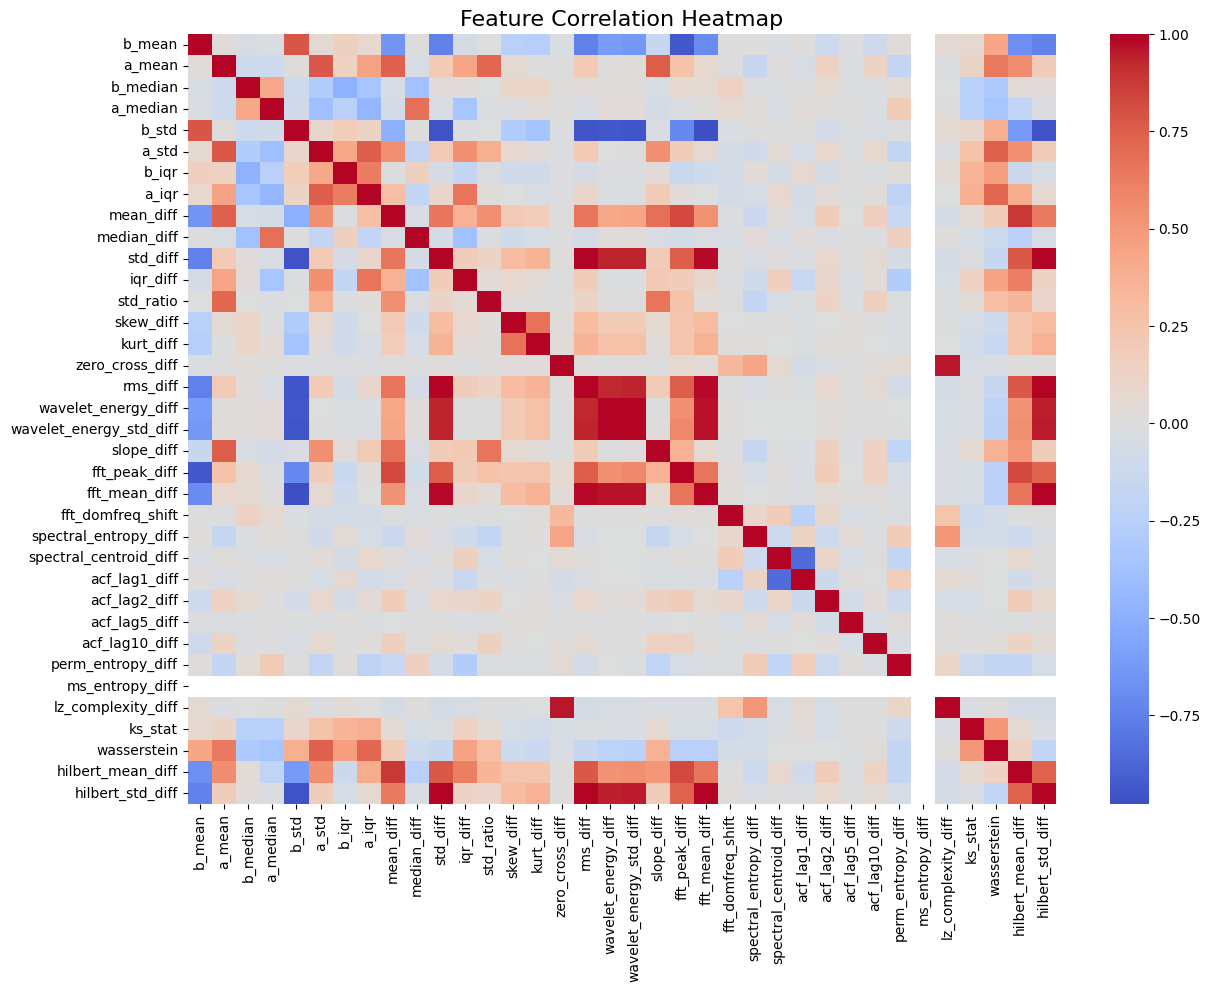

⚠️ Highly Correlated Features:
                    Feature1                 Feature2  Correlation
19                    b_mean            fft_peak_diff    -0.932217
135                    b_std                 std_diff    -0.955735
141                    b_std                 rms_diff    -0.954941
142                    b_std      wavelet_energy_diff    -0.947328
143                    b_std  wavelet_energy_std_diff    -0.953054
146                    b_std            fft_mean_diff    -0.978282
159                    b_std         hilbert_std_diff    -0.962641
300                 std_diff                 rms_diff     0.999988
301                 std_diff      wavelet_energy_diff     0.931146
302                 std_diff  wavelet_energy_std_diff     0.937520
305                 std_diff            fft_mean_diff     0.982191
318                 std_diff         hilbert_std_diff     0.998541
419          zero_cross_diff       lz_complexity_diff     0.959804
424                 rms_diff   

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# correlation matrix
corr_matrix = X_features.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()

# Highly correlated pairs list
threshold = 0.9
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ["Feature1", "Feature2", "Correlation"]
high_corr = corr_pairs[abs(corr_pairs["Correlation"]) > threshold]

print("⚠️ Highly Correlated Features:")
print(high_corr)


### XGBoost + SHAP pipeline for feature impoortances


[Fold 1] ROC-AUC: 0.7068
[Fold 2] ROC-AUC: 0.6647
[Fold 3] ROC-AUC: 0.7073
[Fold 4] ROC-AUC: 0.6781
[Fold 5] ROC-AUC: 0.6741

✅ CV ROC-AUC: 0.6859748040631628


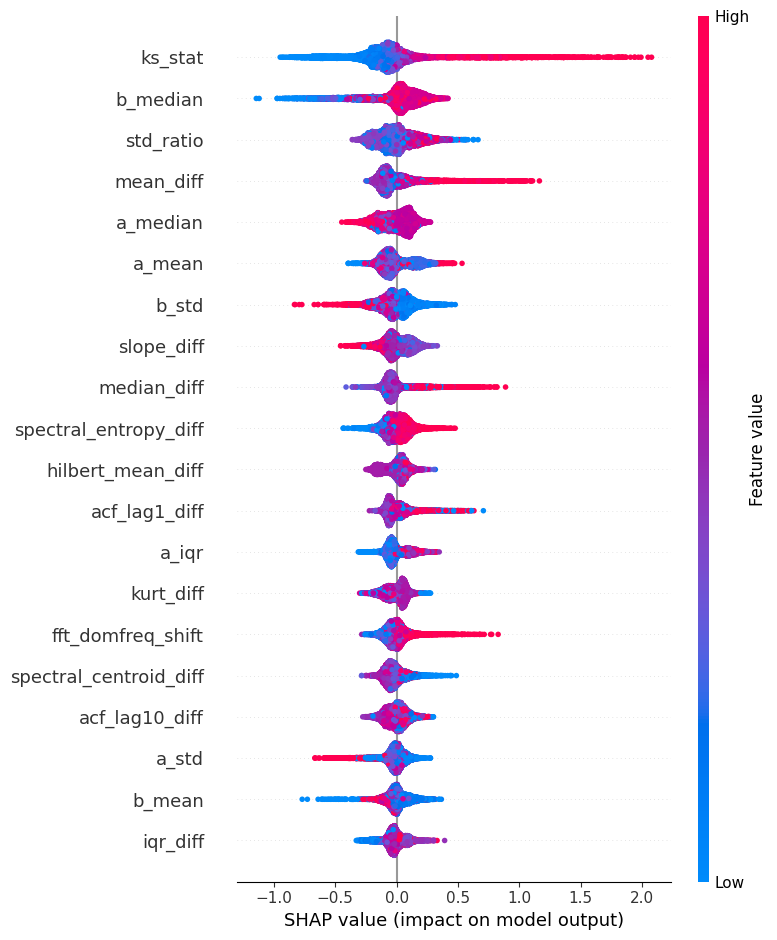


🔝 Top Features by SHAP:
                   feature  importance
32                 ks_stat    0.214163
2                 b_median    0.141710
12               std_ratio    0.118286
8                mean_diff    0.112531
3                 a_median    0.101849
1                   a_mean    0.098756
4                    b_std    0.097013
19              slope_diff    0.084338
9              median_diff    0.078675
23   spectral_entropy_diff    0.075506
34       hilbert_mean_diff    0.070712
25           acf_lag1_diff    0.068970
7                    a_iqr    0.068549
14               kurt_diff    0.065834
22       fft_domfreq_shift    0.064245
24  spectral_centroid_diff    0.064122
28          acf_lag10_diff    0.064011
5                    a_std    0.063124
0                   b_mean    0.062822
11                iqr_diff    0.062027

⚠️ Dropping 7 correlated features: ['std_diff', 'fft_mean_diff', 'wavelet_energy_diff', 'wavelet_energy_std_diff', 'rms_diff', 'zero_cross_diff', 'hilbert_

In [18]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 1) Train XGBoost with CV
# ---------------------------
def train_xgb_with_shap(X, y, n_splits=5, seed=42):
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof_preds = np.zeros(len(X))
    models = []

    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "learning_rate": 0.05,
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "reg_lambda": 1.0,
        "random_state": seed,
        "n_estimators": 500
    }

    for fold, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        model = xgb.XGBClassifier(**params, use_label_encoder=False)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  verbose=False,
                  early_stopping_rounds=50)

        oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
        models.append(model)

        auc = roc_auc_score(y_val, oof_preds[val_idx])
        print(f"[Fold {fold+1}] ROC-AUC: {auc:.4f}")

    final_auc = roc_auc_score(y, oof_preds)
    print("\n✅ CV ROC-AUC:", final_auc)

    return models, oof_preds, final_auc

# ---------------------------
# 2) SHAP Analysis
# ---------------------------
def shap_analysis(model, X, max_display=20):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    # Summary plot (global feature importance)
    shap.summary_plot(shap_values, X, max_display=max_display, show=False)
    plt.show()

    # Mean absolute shap values = importance ranking
    importance_df = pd.DataFrame({
        "feature": X.columns,
        "importance": np.abs(shap_values).mean(axis=0)
    }).sort_values("importance", ascending=False)

    print("\n🔝 Top Features by SHAP:")
    print(importance_df.head(20))

    return importance_df

# ---------------------------
# 3) Correlation Filtering
# ---------------------------
def correlation_filter(X, importance_df, threshold=0.95):
    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    to_drop = []
    for col in upper.columns:
        high_corr = [row for row in upper.index if upper.loc[row, col] > threshold]
        for hc in high_corr:
            # drop the one with lower SHAP importance
            if importance_df.set_index("feature").loc[hc, "importance"] < \
               importance_df.set_index("feature").loc[col, "importance"]:
                to_drop.append(hc)
            else:
                to_drop.append(col)

    to_drop = list(set(to_drop))
    print(f"\n⚠️ Dropping {len(to_drop)} correlated features:", to_drop)
    return X.drop(columns=to_drop)

# ---------------------------
# 🔹 Usage
# ---------------------------
# Example:
# X_features, y_features = build_all_features(X_train, y_train)

models, oof_preds, cv_auc = train_xgb_with_shap(X_features, y_features)

# SHAP analysis on best model (e.g., first fold)
importance_df = shap_analysis(models[0], X_features)

# Correlation filtering based on SHAP
X_filtered = correlation_filter(X_features, importance_df, threshold=0.95)


## 🔎 SHAP Feature Importance & Correlated Feature Handling

### Top Features by SHAP
The SHAP analysis highlights the most influential features driving our structural break predictions:

- **`ks_stat` (0.214)** → Strongest feature; captures the Kolmogorov–Smirnov statistic difference, highly indicative of distribution shifts.
- **`b_median` (0.141)** and **`a_median` (0.102)** → Median values of series segments before and after the breakpoint, reflecting central tendency changes.
- **`std_ratio` (0.118)** and **`mean_diff` (0.113)** → Capture dispersion and mean-level changes across segments.
- **Higher-order features** such as `spectral_entropy_diff`, `hilbert_mean_diff`, and `acf_lag1_diff` provide insights into frequency-domain and autocorrelation dynamics.
- **Other contributors** like `kurt_diff` and `fft_domfreq_shift` capture shape and frequency distribution differences.

Overall, the top features combine **statistical shifts (mean, median, std)** with **spectral and autocorrelation features**, ensuring both time-domain and frequency-domain perspectives.

---

### ⚠️ Dropping Correlated Features
To reduce multicollinearity and simplify the model, we removed **7 highly correlated features**:

- `std_diff`
- `fft_mean_diff`
- `wavelet_energy_diff`
- `wavelet_energy_std_diff`
- `rms_diff`
- `zero_cross_diff`
- `hilbert_std_diff`

These features contained overlapping information with retained features (e.g., `std_ratio`, `spectral_entropy_diff`), so dropping them helps:
- Improve model stability
- Reduce overfitting
- Speed up training and inference

---

✅ **Final takeaway:**  
Our feature set is now leaner and more interpretable, focusing on **distributional changes, spectral dynamics, and autocorrelation shifts**, which SHAP confirms as the key drivers of structural break detection.
